In [ ]:
# AI Testing Demo: House Price Prediction in Google Colab

# 1. Install Dependencies
!pip install shap pandas scikit-learn matplotlib seaborn --quiet



In [ ]:

# 2. Import Libraries
!pip install pandas scikit-learn matplotlib seaborn shap --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [ ]:
# 3. Load and Inspect the Dataset
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data.frame
print(df.head())



   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [ ]:


print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nStatistical Summary:\n", df.describe())

# Check for invalid or impossible values
assert (df['AveRooms'] >= 0).all(), "Invalid values found in AveRooms"
assert (df['HouseAge'] >= 0).all(), "Negative house age detected"
assert (df['MedInc'] <= 100).all(), "Unrealistically high income detected"

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicate_count}")




Missing values:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Data types:
 MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Statistical Summary:
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%  

In [ ]:
from scipy.stats import zscore
import numpy as np
import pandas as pd

# Calculate Z-scores for numeric columns
numeric_cols = df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(numeric_cols))

# Store results in a DataFrame for easier analysis
z_df = pd.DataFrame(z_scores, columns=numeric_cols.columns)

# Count outliers per column (Z-score > 3)
outlier_counts = (z_df > 3).sum()

print("\nNumber of outliers per column:")
print(outlier_counts)

# Optional: Get actual row indexes for each column with outliers
outlier_indices = {col: z_df[z_df[col] > 3].index.tolist() for col in numeric_cols.columns}

print("\nOutlier row indices per column:")
for col, idx_list in outlier_indices.items():
    print(f"{col}: {len(idx_list)} rows → {idx_list[:10]}{'...' if len(idx_list) > 10 else ''}")



Number of outliers per column:
MedInc         345
HouseAge         0
AveRooms       133
AveBedrms      145
Population     342
AveOccup         8
Latitude         0
Longitude        0
MedHouseVal      0
dtype: int64

Outlier row indices per column:
MedInc: 345 rows → [131, 409, 510, 511, 512, 514, 923, 977, 986, 1541]...
HouseAge: 0 rows → []
AveRooms: 133 rows → [1024, 1102, 1233, 1234, 1235, 1238, 1239, 1240, 1566, 1867]...
AveBedrms: 145 rows → [710, 1024, 1102, 1233, 1234, 1235, 1238, 1239, 1240, 1867]...
Population: 342 rows → [283, 570, 576, 780, 799, 864, 865, 867, 869, 871]...
AveOccup: 8 rows → [3364, 8874, 9172, 12104, 13034, 16420, 16669, 19006]
Latitude: 0 rows → []
Longitude: 0 rows → []
MedHouseVal: 0 rows → []


In [ ]:
# 5. Train-Test Split
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# 6. Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [ ]:
# ---------- Edge Case Input Prediction ----------
edge_input = {
    'MedInc': 20.0,          # Very high income
    'HouseAge': 0.0,         # Brand new house
    'AveRooms': 1.0,         # Very few rooms
    'AveBedrms': 0.5,        # Possibly a studio
    'Population': 100.0,     # Very low population
    'AveOccup': 15.0,        # Overcrowded
    'Latitude': 37.0,
    'Longitude': -122.0
}
edge_df = pd.DataFrame([edge_input])
edge_predicted_price = model.predict(edge_df)[0]
print(f"\n⚠️ Predicted House Value for the EDGE case input: {edge_predicted_price:.2f}")


⚠️ Predicted House Value for the EDGE case input: 3.42


In [ ]:

# Make predictions on test data
y_pred = model.predict(X_test)

# Sanity check for prediction range
print("\nSanity Check – Predicted Price Range")
print("Min:", np.min(y_pred), "| Max:", np.max(y_pred))

# Model evaluation metrics
print("\nModel Evaluation:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))



Sanity Check – Predicted Price Range
Min: 0.4884400000000003 | Max: 5.000009999999989

Model Evaluation:
MSE: 0.2553684927247781
MAE: 0.32754256845930246
R2 Score: 0.8051230593157366


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ---- Baseline Prediction ----
y_pred_base = model.predict(X_test)

# 1️⃣ Metamorphic Test: Add small noise to features
print("\nMetamorphic Test: Add small noise to features")
noise = np.random.normal(0, 0.01, X_test.shape)
X_test_noisy = X_test + noise
y_pred_noisy = model.predict(X_test_noisy)

# Expected MR: output should have a small change similar to noise effect
expected_y_noisy = y_pred_base + np.random.normal(0, 0.01, y_pred_base.shape)

print("MAE (noise):", mean_absolute_error(expected_y_noisy, y_pred_noisy))
print("MSE (noise):", mean_squared_error(expected_y_noisy, y_pred_noisy))
print("R2  (noise):", r2_score(expected_y_noisy, y_pred_noisy))


# 2️⃣ Metamorphic Test: Scale all features by a constant factor
print("\nMetamorphic Test: Scale all features by a constant factor")
scale_factor = 1.1
X_test_scaled = X_test * scale_factor
y_pred_scaled = model.predict(X_test_scaled)

# Expected MR: output should also scale by the same factor
expected_y_scaled = y_pred_base * scale_factor

print("MAE (scaled):", mean_absolute_error(expected_y_scaled, y_pred_scaled))
print("MSE (scaled):", mean_squared_error(expected_y_scaled, y_pred_scaled))
print("R2  (scaled):", r2_score(expected_y_scaled, y_pred_scaled))




Metamorphic Test: Add small noise to features
MAE (noise): 0.032241460166710444
MSE (noise): 0.0031230654129661478
R2  (noise): 0.9969243307027787

Metamorphic Test: Scale all features by a constant factor
MAE (scaled): 0.6283330156928292
MSE (scaled): 0.6347842252407476
R2  (scaled): 0.4833699507896979


In [ ]:
# Re-attach demographic attribute
X_test_demo = X_test.copy()
X_test_demo['IncomeGroup'] = pd.qcut(df.loc[X_test.index]['MedInc'], 4, labels=['Low', 'MedLow', 'MedHigh', 'High'])
y_pred_series = pd.Series(y_pred, index=X_test_demo.index)

# Metric calculation by group
fairness_metrics = []
for group in X_test_demo['IncomeGroup'].unique():
    idx = X_test_demo[X_test_demo['IncomeGroup'] == group].index
    actual = y_test.loc[idx]
    predicted = y_pred_series.loc[idx]

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    fairness_metrics.append({
        'Group': group,
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'SampleSize': len(idx)
    })

fairness_report_df = pd.DataFrame(fairness_metrics).set_index('Group')
print("\n📊 Fairness Report:\n", fairness_report_df)



📊 Fairness Report:
               MAE       MSE        R2  SampleSize
Group                                            
Low      0.235069  0.165400  0.654038        1032
MedLow   0.306015  0.221279  0.690583        1039
High     0.417643  0.349327  0.716614        1032
MedHigh  0.351753  0.285907  0.665882        1025



Counterfactual Fairness Test (Avg Δ across 100 samples)
Average change in prediction (Δ) after minor perturbation: 0.000000
✅ Model shows good counterfactual stability.


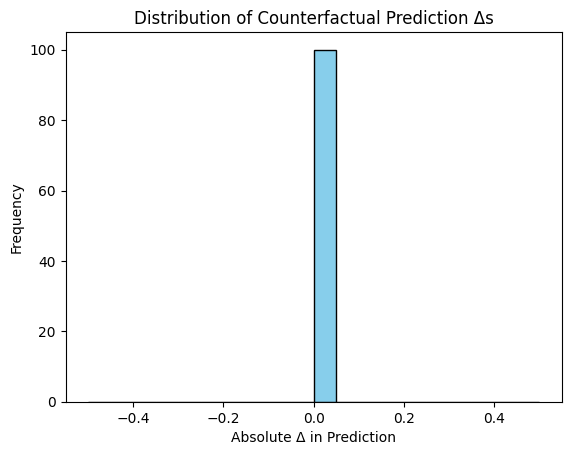

In [ ]:
def test_counterfactual_fairness(sample_idx):
    sample = X_test.iloc[sample_idx].copy()
    sample_df = pd.DataFrame([sample], columns=X_test.columns)
    original_pred = model.predict(sample_df)[0]
    altered_sample = sample.copy()
    altered_sample['AveOccup'] += 1e-5  # simulate a minor perturbation
    altered_df = pd.DataFrame([altered_sample], columns=X_test.columns)
    cf_pred = model.predict(altered_df)[0]
    delta = abs(original_pred - cf_pred)
    return delta

# Run over multiple samples to assess average sensitivity
print("\nCounterfactual Fairness Test (Avg Δ across 100 samples)")
counterfactual_deltas = [test_counterfactual_fairness(i) for i in range(100)]
avg_delta = np.mean(counterfactual_deltas)
print(f"Average change in prediction (Δ) after minor perturbation: {avg_delta:.6f}")
if avg_delta > 0.01:
    print("⚠️ Warning: Model may be overly sensitive to small irrelevant changes!")
else:
    print("✅ Model shows good counterfactual stability.")

# 🔍 Optional: Visualize distribution of deltas
import matplotlib.pyplot as plt
plt.hist(counterfactual_deltas, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Counterfactual Prediction Δs")
plt.xlabel("Absolute Δ in Prediction")
plt.ylabel("Frequency")
plt.show()


Global feature importance (SHAP):


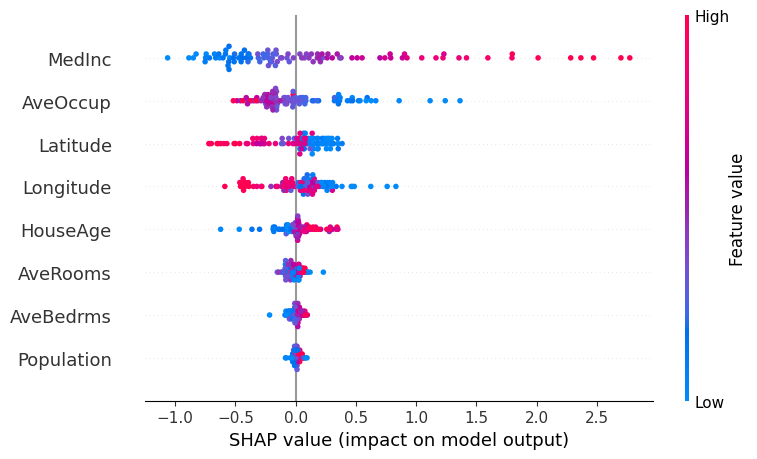

In [ ]:
# Initialize SHAP Explainer for the trained Random Forest model
explainer = shap.TreeExplainer(model)

# Sample a small batch for local explanations
X_sample = X_test.sample(100, random_state=42)
shap_values = explainer.shap_values(X_sample)

# Global Explainability: Feature Importance summary across all test points
print("Global feature importance (SHAP):")
shap.summary_plot(shap_values, X_sample)



In [ ]:

print("\nRobustness Test: Inject Out-of-Range Input")
outlier_input = X_test.iloc[0].copy()
outlier_input['AveRooms'] = 1000  # unrealistic value
outlier_input['AveBedrms'] = 500
outlier_input_df = pd.DataFrame([outlier_input], columns=X_test.columns)
pred_outlier = model.predict(outlier_input_df)
print("Prediction for Outlier Input:", pred_outlier[0])
y_actual = y_test.iloc[0]
print(y_actual)

print("\nAdversarial Test: Add subtle perturbation to a normal input")
adversarial_input = X_test.iloc[1].copy() + 0.05  # small noise
adversarial_input_df = pd.DataFrame([adversarial_input], columns=X_test.columns)
pred_adv = model.predict(adversarial_input_df)
print("Prediction for Slightly Perturbed Input:", pred_adv[0])

print("\nEvaluate on adversarial input compared to actual")
y_actual = y_test.iloc[1]
print("Actual Value:", y_actual)
print("MAE (adversarial):", mean_absolute_error([y_actual], pred_adv))
print("MSE (adversarial):", mean_squared_error([y_actual], pred_adv))





Robustness Test: Inject Out-of-Range Input
Prediction for Outlier Input: 2.077852299999999
0.477

Adversarial Test: Add subtle perturbation to a normal input
Prediction for Slightly Perturbed Input: 0.7512399999999998

Evaluate on adversarial input compared to actual
Actual Value: 0.458
MAE (adversarial): 0.2932399999999998
MSE (adversarial): 0.08598969759999987
